In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare_2 

<class 'dict'>

The API accepts GET requests for all endpoints, where endpoints are prefixed
with

    /api/{version}

Where version is "v1"

Valid endpoints:

- /stores[/{store_id}]
- /items[/{item_id}]
- /sales[/{sale_id}]

All endpoints accept a `page` parameter that can be used to navigate through
the results.

max_page: 3
next_page: /api/v1/items?page=2
max_page: 3
next_page: /api/v1/items?page=3
max_page: 3
next_page: None
max_page: 1
next_page: None
max_page: 183
next_page: /api/v1/sales?page=2


### Acquire data

In [2]:
df = acquire.get_all_data()
df.head()

,item_id,sale_amount,sale_date,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253


### Prep data

1. Create column ds that is sale_date converted to dtype of datetime.

2. Sort ds to be in ascending order.

3. Compute y which represents item sales = sale_amount * item_price. ds and y are the column names required by the Prophet API.

4. Sum all the item sales, y, over each day, i.e. group by ds.

5. Set the dataframe index to be the datetime columns, ds.

6. Return the prepared dataframe.

In [3]:
def prepare_store_data(df: pd.DataFrame) -> pd.DataFrame:
    return (df.assign(ds=pd.to_datetime(df.sale_date)).sort_values('ds')
            .assign(y=df.sale_amount * df.item_price)\
            .groupby(['ds'])['y'].sum().reset_index().set_index('ds'))

In [4]:
heb = prepare_store_data(df)

In [5]:
heb.head()

,y
ds,
2013-01-01 00:00:00+00:00,73844.01
2013-01-02 00:00:00+00:00,73570.58
2013-01-03 00:00:00+00:00,78169.48
2013-01-04 00:00:00+00:00,84467.73
2013-01-05 00:00:00+00:00,87621.85


In [6]:
heb = heb.resample('w').agg('sum')
heb.head()

,y
ds,
2013-01-06 00:00:00+00:00,490767.50
2013-01-13 00:00:00+00:00,559934.21
2013-01-20 00:00:00+00:00,552813.52
2013-01-27 00:00:00+00:00,554908.84
2013-02-03 00:00:00+00:00,586547.55


### Split data

1. We will use the training proportion method to split.

2. Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)

3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.

4. Return train and test dataframes.

In [7]:
def split_store_data(heb, train_prop=.66): 
    train_size = int(len(heb) * train_prop)
    train, test = heb[0:train_size].reset_index(), heb[train_size:len(heb)].reset_index()
    return train, test

In [8]:
train, test = split_store_data(heb, train_prop=.66)

print('Observations: %d' % (len(heb)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 261
Training Observations: 172
Testing Observations: 89


Plot the data first, viewing where the data is split into train and test.

In [9]:
train = train.set_index('ds')
test = test.set_index('ds')

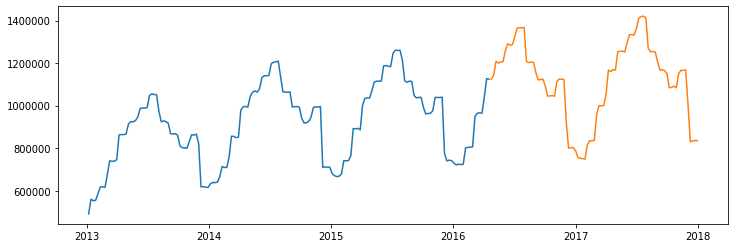

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)

The following functions are for evaluating each of the following different methods for forecasting sales (sales = sale_amount * item_price).

The evaluate( ) will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.
We also have a function, plot_and_eval( ) that will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [11]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [12]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

Create the empty dataframe, eval_df( ) to capture all the evaluation metrics of each of the models we try out. I will also write a function to more efficiently append new metrics to the dataframe.

In [13]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object.

In [14]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)


### Last observed value

In [15]:
yhat = pd.DataFrame(test.y)

The following cell finds the last observation for y and assigns the value as the prediction.

In [16]:
yhat['y'] = int(train.y[-1:])

y -- MSE: 33452573044.35 RMSE: 182900.45


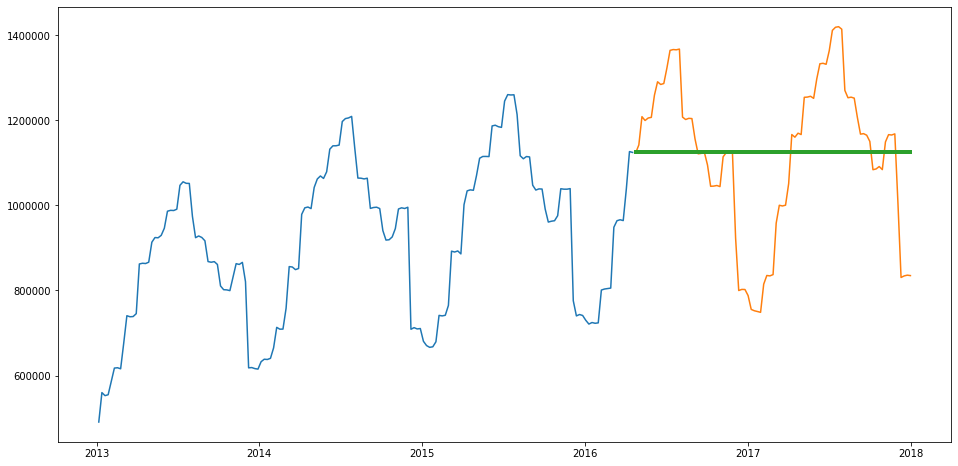

In [17]:
plot_and_eval(target_vars = 'y', train = train, test = test)

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df( )

In [18]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_vars=['y'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,y,mse,3.345257e+10
1,last_observed_value,y,rmse,1.829004e+05


### Simple Average

Take the simple average of historical values and use that value to predict future values.
This is a good option for an initial baseline.
Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

In [19]:
yhat['y'] = train.y.mean()

Now, let's plot and evaluate the performance of our time series model using Simple Average

y -- MSE: 77660633153.03 RMSE: 278676.57


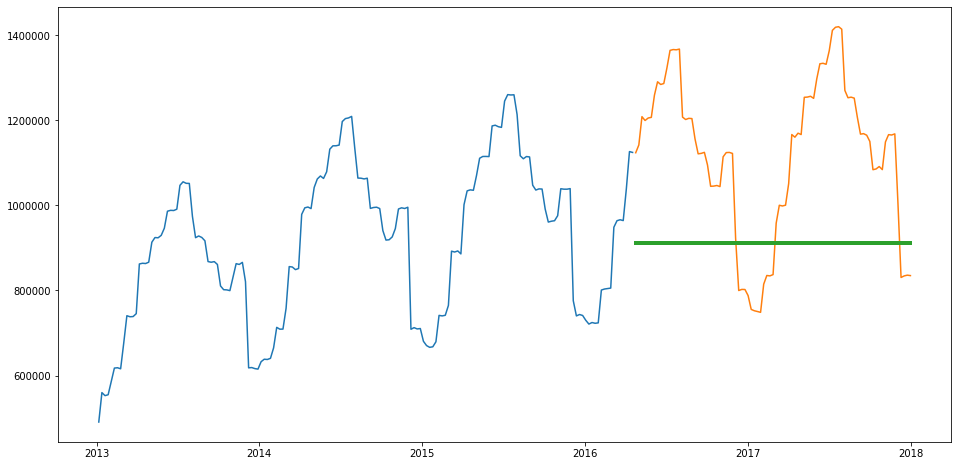

In [20]:
target_vars = ['y']
plot_and_eval(target_vars, train = train, test = test)

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df( )

In [21]:
eval_df = append_eval_df(model_type='simple_average', target_vars=['y'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,y,mse,3.345257e+10
1,last_observed_value,y,rmse,1.829004e+05
2,simple_average,y,mse,7.766063e+10
3,simple_average,y,rmse,2.786766e+05


### Moving Average

In [22]:
periods = 4
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

Now, let's plot and evaluate the performance of our time series model using Moving Average

y -- MSE: 36755779271.77 RMSE: 191717.97


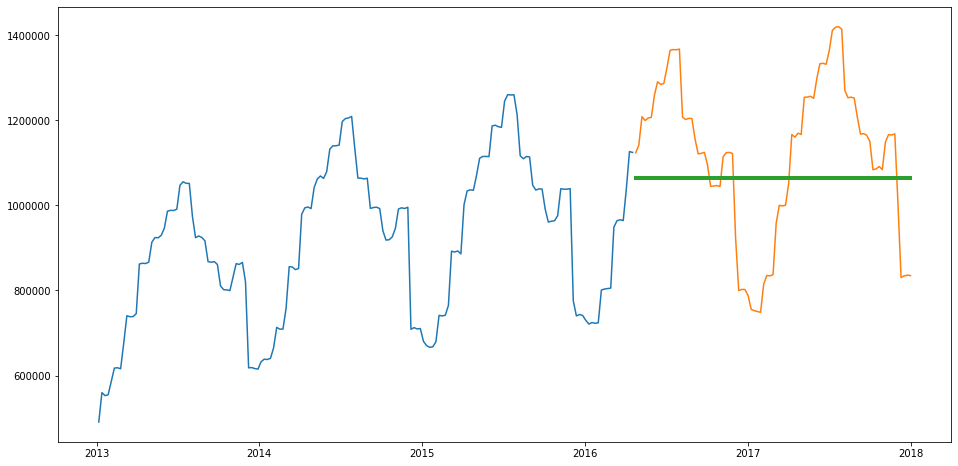

In [23]:
plot_and_eval(target_vars, train = train, test = test)

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df( )

In [24]:
eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,y,mse,3.345257e+10
1,last_observed_value,y,rmse,1.829004e+05
2,simple_average,y,mse,7.766063e+10
3,simple_average,y,rmse,2.786766e+05
4,moving_average,y,mse,3.675578e+10
5,moving_average,y,rmse,1.917180e+05


y -- MSE: 82062900832.21 RMSE: 286466.23


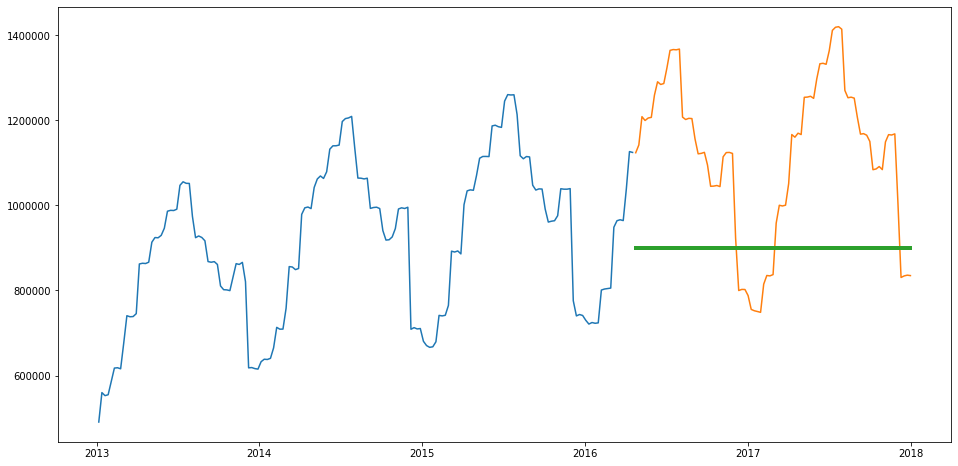


rolling averge period: 1

item sales

MSE:  33452577454.121067
RMSE: 182900.45777449838

rolling averge period: 4

item sales

MSE:  36755779271.76612
RMSE: 191717.96804620614

rolling averge period: 12

item sales

MSE:  72848005055.14304
RMSE: 269903.6958901138

rolling averge period: 26

item sales

MSE:  88198884811.3801
RMSE: 296982.97057471174

rolling averge period: 52

item sales

MSE:  47468695085.94296
RMSE: 217873.1169418177

rolling averge period: 104

item sales

MSE:  54137795876.40474
RMSE: 232675.30138887698


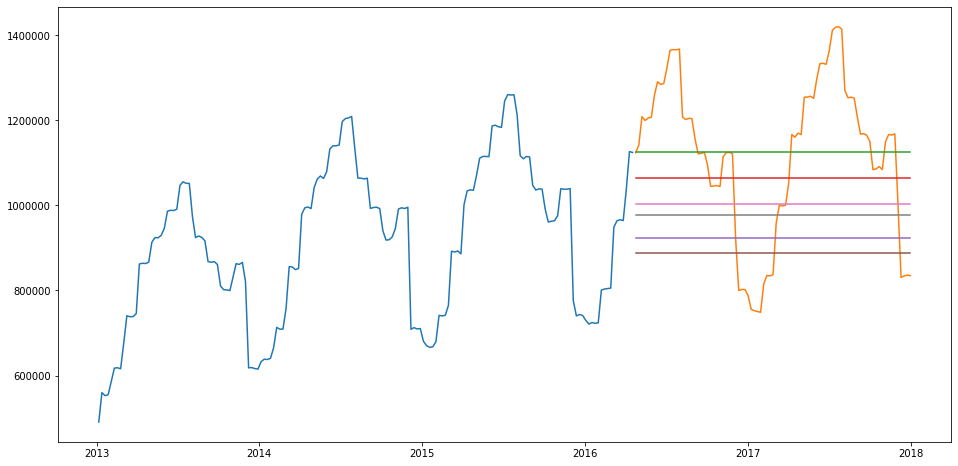

In [25]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    yhat['y'] = train.y.rolling(p).mean().iloc[-1]
    plt.plot(yhat.y)
    print('\nrolling averge period:',p)
    print('\nitem sales\n')
    evaluate('y', train = train, test = test)